In [1]:
import pandas as pd

In [2]:
combination_df = pd.read_csv('/kaggle/input/stanza-goodnews/results/combination_out.csv')
combination_df = combination_df[combination_df['emotion'].isin(['anger', 'negative_surprise', 'positive_surprise', 'fear'])]
print(f'Dataset size: {len(combination_df)}')
combination_df.head()

Dataset size: 2303


,Unnamed: 0,dataset_id,text,emotion,dataset_cue,stanza_root,coincided
0,0,7d3fe468,Cops in One Village Have Been Convicted of 70 ...,anger,convicted,convicted,1
1,1,86693d59,DIY penis enlargements are a 'nationwide probl...,negative_surprise,problem,problem,1
2,2,0fb40e90,Dam breaking: New Epstein accuser comes forward,anger,accuser,breaking,0
3,3,fa7750d6,David Beckham gets six-month driving ban for u...,negative_surprise,ban,gets,0
6,6,06baecb6,Detention centres 'will shock the conscience o...,negative_surprise,shock,shock,1


In [3]:
from sklearn import preprocessing

sentences = combination_df["text"].values
labels = combination_df["emotion"].values
print(f'Number of sentences: {len(sentences)} (same as dataset and labels count)')

le = preprocessing.LabelEncoder()
le.fit(combination_df.emotion)

le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
numeric_labels = le.transform(combination_df.emotion)
unique_numeric_labels = list(set(numeric_labels))

le_name_mapping

Number of sentences: 2303 (same as dataset and labels count)


{'anger': 0, 'fear': 1, 'negative_surprise': 2, 'positive_surprise': 3}

In [4]:
print(f'Total num: {len(combination_df)}')
print(f'Num_of_coincided: {len(combination_df[combination_df["coincided"] == 1])}')

Total num: 2303
Num_of_coincided: 699


In [5]:
import torch
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)


MAX_SENTENCE_LEN = 50

input_encoded = []
attention_masks = []
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_SENTENCE_LEN,           # Pad & truncate all sentences.
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    input_encoded.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    
input_ids = torch.cat(input_encoded, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
input_labels = torch.tensor(numeric_labels)

print(f'Number of input token lists: {len(input_ids)}')
print(f'Number of attention masks: {len(attention_masks)}')
print(f'Number of input numeric labels: {len(input_labels)}')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Number of input token lists: 2303
Number of attention masks: 2303
Number of input numeric labels: 2303


In [6]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, input_labels)

train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size)//2
test_size = len(dataset) - train_size - val_size



# Divide the dataset by randomly selecting samples.

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{} training samples'.format(train_size))
print('{} validation samples'.format(val_size))
print('{} test samples'.format(test_size))

1842 training samples
230 validation samples
231 test samples


In [7]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('Use:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
Use: Tesla T4


In [8]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [9]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained("bert-large-uncased",
                                                      num_labels = 4,
                                                      output_attentions = False,
                                                      output_hidden_states = False,
                                                    )
model.cuda()

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [10]:
optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=2e-5)

In [11]:
from transformers import get_linear_schedule_with_warmup

epochs = 8
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [12]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [13]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [14]:
import random
import numpy as np

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_train_accuracy += flat_accuracy(logits, label_ids)

    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    print("Average train accuracy: {0:.2f}".format(avg_train_accuracy))
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epcoh took: {:}".format(training_time))

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("Average validation accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("Validation Loss: {0:.2f}".format(avg_val_loss))
    print("Validation took: {:}".format(validation_time))

    training_stats.append(

        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Accur.': avg_train_accuracy,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 8 ========
Training...
Batch    10  of     58.    Elapsed: 0:00:09.
Batch    20  of     58.    Elapsed: 0:00:18.
Batch    30  of     58.    Elapsed: 0:00:26.
Batch    40  of     58.    Elapsed: 0:00:35.
Batch    50  of     58.    Elapsed: 0:00:44.
Average train accuracy: 0.41

Average training loss: 1.30
Training epcoh took: 0:00:50

Running Validation...
Average validation accuracy: 0.50
Validation Loss: 1.08
Validation took: 0:00:02

======== Epoch 2 / 8 ========
Training...
Batch    10  of     58.    Elapsed: 0:00:09.
Batch    20  of     58.    Elapsed: 0:00:18.
Batch    30  of     58.    Elapsed: 0:00:27.
Batch    40  of     58.    Elapsed: 0:00:36.
Batch    50  of     58.    Elapsed: 0:00:45.
Average train accuracy: 0.59

Average training loss: 0.97
Training epcoh took: 0:00:52

Running Validation...
Average validation accuracy: 0.58
Validation Loss: 0.97
Validation took: 0:00:02

======== Epoch 3 / 8 ========
Training...
Batch    10  of     58.    Elapsed: 0:0

In [15]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,1.301681,0.405891,1.084583,0.497396,0:00:50,0:00:02
2,0.971928,0.592433,0.972531,0.579427,0:00:52,0:00:02
3,0.715785,0.722761,1.004238,0.595052,0:00:53,0:00:02
4,0.486298,0.836506,1.050450,0.595052,0:00:53,0:00:02
5,0.309365,0.901640,1.145689,0.587240,0:00:53,0:00:02
6,0.189183,0.951628,1.231348,0.619792,0:00:53,0:00:02
7,0.126151,0.972102,1.316339,0.610677,0:00:53,0:00:02
8,0.097657,0.978987,1.357714,0.610677,0:00:52,0:00:02


In [16]:
model.save_pretrained(save_directory="finetuned")

----------


In [17]:
batch_size = 32

test_dataloader = DataLoader(
            test_dataset,
            sampler = RandomSampler(test_dataset),
            batch_size = batch_size
        )

In [18]:
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)
    
  with torch.no_grad():
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

    DONE.


In [19]:
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

true_labels = np.concatenate(true_labels, axis=0)

<Axes: >

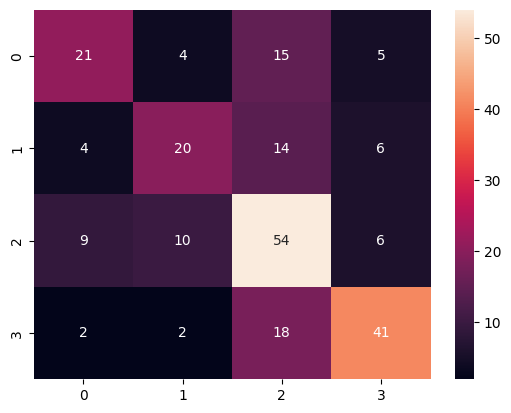

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(true_labels, flat_predictions)
sns.heatmap(cf_matrix, annot=True)

----

In [21]:
from transformers import TextClassificationPipeline
from transformers import BertTokenizer, AutoModel, BertForSequenceClassification
import numpy as np

map_full = {'anger': 0, 'annoyance': 1, 'disgust': 2, 'fear': 3, 'negative_surprise': 4, 'positive_surprise': 5, 'sadness': 6}
map_small = {'anger': 0, 'fear': 1, 'negative_surprise': 2, 'positive_surprise': 3}

inv_map_full = {v: k for k, v in map_full.items()}
inv_map_small = {v: k for k, v in map_small.items()}

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained('/kaggle/input/bertfinetunednews/transformers/4emotionsnews/1')

inputs = tokenizer("His Visa Was Stamped, His Papers in Order. Then He Was Targeted By a Secretive CBP Task Force.", return_tensors="pt")
outputs = model(**inputs)

prediction_logits = outputs.logits.detach().cpu().numpy()[0]

index_max = np.argmax(prediction_logits)
print(f'Emotion: {inv_map_small[index_max]}')

Emotion: negative_surprise
